# Analysing Titanic Passenger Data

This report is prepared as the completion project for Udacity Data Analysis Nanodegree, Stage 2

### Info About the Dataset

First thing we will do is to import the data and have a glimpse. A quick look to csv file makes clear that PassengerId column is the unique identifier, so it could be used as the index column.

In [1]:
import pandas as pd
import numpy as np

#Import titanic-data.csv file as a pandas dataframe
#Choose 'PassengerId' as index column.
titandf = pd.read_csv('titanic-data.csv', index_col = 'PassengerId') 

Printing some example columns to make sure the file is imported to dataframe properly.

In [2]:
print len(titandf)                        #Print length of the dataset
print titandf.loc[1]                      #Print passenger column with id 1
print titandf.loc[199]                    #Print passenger column with id 199

891
Survived                          0
Pclass                            3
Name        Braund, Mr. Owen Harris
Sex                            male
Age                              22
SibSp                             1
Parch                             0
Ticket                    A/5 21171
Fare                           7.25
Cabin                           NaN
Embarked                          S
Name: 1, dtype: object
Survived                                   1
Pclass                                     3
Name        Madigan, Miss. Margaret "Maggie"
Sex                                   female
Age                                      NaN
SibSp                                      0
Parch                                      0
Ticket                                370370
Fare                                    7.75
Cabin                                    NaN
Embarked                                   Q
Name: 199, dtype: object


Seems fine. We have 891 passengers onboard (actual number is higher than that but we will ignore this for this exercise). However looking those examples, two points arise:

**1** - Some column names are self explanatory, but some are not (i.e SibSp). What do they mean?

**2** - There are some null values, which would negatively affect the analysis. It's necessary to know which columns are complete, and which columns contain null values.

For the first point, we turn to Kaggle, where we originally imported the data. [This link](https://www.kaggle.com/c/titanic/data "Titanic: Machine Learning From Disaster") describe all the variables.

Printing number of null values in each column should give us an idea about the second point.

In [3]:
def total_null(data):                        #Returns number of nulls in given argument
    return data.isnull().sum()               

titandf.apply(total_null, axis=0)            #Apply total_null function to all *columns* - that's why the axis is 0

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Turns out almost one fifth of the passengers do not have age information. This should be kept in mind while doing any age related analysis, and we need to decide what to do with those null values.

### Posing the Question

The main quesion to focus for this practice is quite straightforward - **what factors made people more likely to survive?** Looking at the examples printed and variable description, I will focus on 3 variables:

- **Fare**
- **Age**
- **Gender**

## Fare

In [4]:
titandf['Fare'].describe()                    #Describe fare column

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

This gives an idea about what is the range we are dealing with, and looking at the mean and standard deviation, we can expect a positively skewed distribution. However, visualising the distribution will give us a more accurate picture.

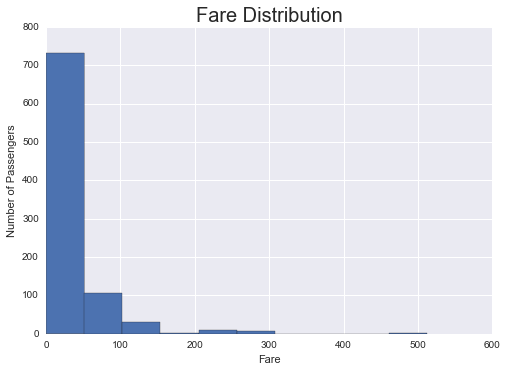

In [5]:
import matplotlib.pyplot as plt                   
%matplotlib inline

import seaborn as sns                             #Import Seaborn for pretty graphs
sns.set(color_codes=True)

titandf['Fare'].hist()                            #Print histogram for 'Fare'
plt.title('Fare Distribution', fontsize = 20)
plt.xlabel('Fare')
plt.ylabel('Number of Passengers')

As expected, it's a positively skewed distribution, however these standard bin sizes prevent does not help to have a good idea about the distribution. After some trial-error, I came up with the bins below.

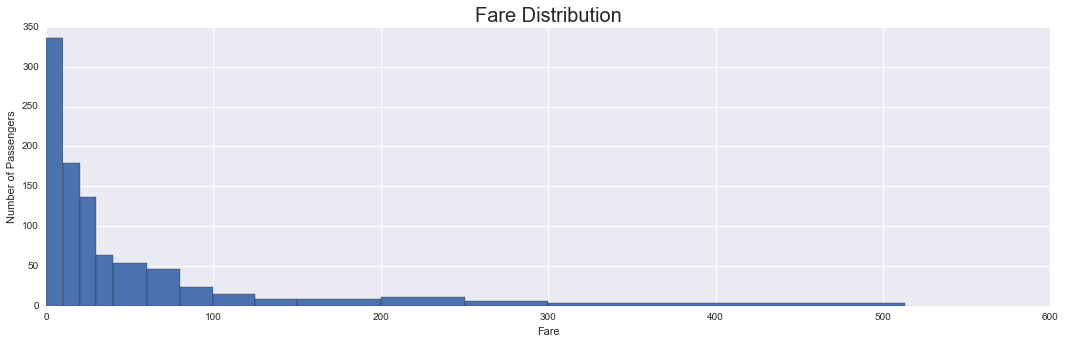

In [6]:
fare_bins = [0,10,20,30,40,60,80,100,125,150,200,250,300,513]

#Passing the fare_bins and making the graph bigger using figsize
titandf['Fare'].hist(bins=fare_bins, figsize=(18,5))
plt.title('Fare Distribution', fontsize = 20)
plt.xlabel('Fare')
plt.ylabel('Number of Passengers')

The next thing I'd like to see is the survivors in each bin.

Populating the interactive namespace from numpy and matplotlib


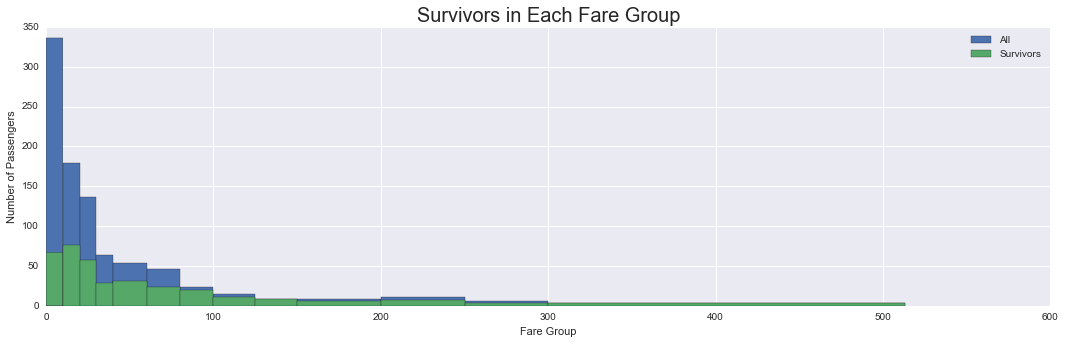

In [7]:
#Query titandf and filter the survivors
survivors = titandf[(titandf['Survived'] == 1)]        

#Store fare column for all passengers
all_fares = titandf['Fare']

#Store fare column for survivors only
survivor_fares = survivors['Fare']                                  

#Using pyplot hist function to map two histograms together.
%pylab inline                                          
pylab.rcParams['figure.figsize'] = (18, 5)           

plt.hist(all_fares, fare_bins, label='All')                   
plt.hist(survivor_fares, fare_bins, label='Survivors')
plt.ylabel('Number of Passengers')
plt.xlabel('Fare Group')
plt.title('Survivors in Each Fare Group', fontsize = 20)

#Locate the legend on upper right
plt.legend(loc='upper right')                              
plt.show()

Alright. Seems like if you paid more, your chances to survive was higher. However we still don't know that for sure. Therefore we need to know exact percentage of survivors in each fare group. For that, I will group all the fares based on the bin sizes above, and add that to the dataframe in another column.

In [8]:
#Classifying fares into fare groups and adding a column to dataframe for fare groups.
fare_group_names = ['0-10', '10-20','20-30','30-40','40-60','60-80','80-100','100-125',
                    '125-150','150-200','200-250','250-300', '300+']

titandf['Fare_Group'] = pd.cut(titandf['Fare'], fare_bins, labels=fare_group_names, include_lowest= True)

In [9]:
titandf.loc[200]                #Checking if fare classification worked

Survived                                           0
Pclass                                             2
Name          Yrois, Miss. Henriette ("Mrs Harbeck")
Sex                                           female
Age                                               24
SibSp                                              0
Parch                                              0
Ticket                                        248747
Fare                                              13
Cabin                                            NaN
Embarked                                           S
Fare_Group                                     10-20
Name: 200, dtype: object

Since we organised fare groups, we can now check the percentage of survivors in each fare group. My goal is to write a function which I could apply to fare group, and store it's output in another column in case I would improve this analysis in future for a machine learning application.

In [10]:
def survivor_percentage_fare(fare_group):
    all_fare_group = titandf[titandf['Fare_Group'] == fare_group]                #Filter the fare group
    survivors_in_group = len(all_fare_group[titandf['Survived'] == 1]) #Filter survivors in that fare group
    survivor_percentage = float(survivors_in_group) / float(len(all_fare_group)) #Divide survivors to fare group size
    return survivor_percentage                                                   #Return percentage

titandf['Fare_Group_Survival_Rate'] = titandf['Fare_Group'].apply(survivor_percentage_fare)

/Users/emreergin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [11]:
titandf.loc[150]    #Checking if the function above worked.

Survived                                                    0
Pclass                                                      2
Name                        Byles, Rev. Thomas Roussel Davids
Sex                                                      male
Age                                                        42
SibSp                                                       0
Parch                                                       0
Ticket                                                 244310
Fare                                                       13
Cabin                                                     NaN
Embarked                                                    S
Fare_Group                                              10-20
Fare_Group_Survival_Rate                             0.424581
Name: 150, dtype: object

Next thing I want to do is to visualise the relationship between fare groups and the survival rate. A scatter plot should give me what I need. However, to prepare the data to be plotted I need to do some cleaning.

In [12]:
#Save all fare groups and corresponding survival rates into a single dataframe.
unique_fares_and_survival = pd.unique(titandf[['Fare_Group', 'Fare_Group_Survival_Rate']].values)
unique_fares_and_survival = list(unique_fares_and_survival)
survival_rates_for_fare = pd.DataFrame.from_records(unique_fares_and_survival, columns = ['FareGroup', 'SurvivalRate'])
survival_rates_for_fare

,FareGroup,SurvivalRate
0,0-10,0.199405
1,60-80,0.520833
2,40-60,0.574074
3,20-30,0.443662
4,10-20,0.424581
5,30-40,0.396552
6,250-300,0.666667
7,125-150,0.888889
8,80-100,0.857143
9,200-250,0.636364


I might need to do the same operation for other variables, so I'm saving a function to create a dataframe with survival rates and categories for a given variable.

In [13]:
def category_survival_rate_df_generator(category, category_survival_rate):
    '''Creates a dataframe with all categories and corresponding survival rates'''
    a = pd.unique(titandf[[category, category_survival_rate]].values)   #Creates an array of tuples with unique values
    a = list(a)                                                         #Converting into a list, to easen dataframe conversion
    df = pd.DataFrame.from_records(a, columns=[category, 'Survival_Rate']) 
    return df

In [14]:
category_survival_rate_df_generator('Fare_Group', 'Fare_Group_Survival_Rate')

,Fare_Group,Survival_Rate
0,0-10,0.199405
1,60-80,0.520833
2,40-60,0.574074
3,20-30,0.443662
4,10-20,0.424581
5,30-40,0.396552
6,250-300,0.666667
7,125-150,0.888889
8,80-100,0.857143
9,200-250,0.636364


Bin sizes are saved in string format, and they cannot be plotted. I will do a quick regex operation to get the lower bound of the bin, and use that for plotting.

In [15]:
import re

def binsize_splitter_low(data):
    '''Splits the bin size string and returns the first figure as integer'''
    if data == None:
        return 0
    else:
        lowerbound, higherbound = re.split(r'[-+]', data)
        return int(lowerbound)

In [16]:
survival_rates_for_fare['BinLowerBound'] = survival_rates_for_fare['FareGroup'].apply(binsize_splitter_low)
survival_rates_for_fare.loc[1]

FareGroup           60-80
SurvivalRate     0.520833
BinLowerBound          60
Name: 1, dtype: object

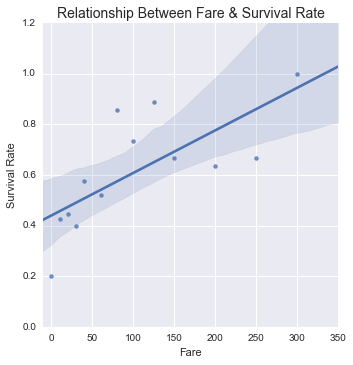

In [17]:
#Create a scatter plot using seaborn
fare_survive_sp = sns.lmplot('BinLowerBound', 'SurvivalRate', data=survival_rates_for_fare)

#Set labels and limits for both axis
fare_survive_sp = (fare_survive_sp.set_axis_labels("Fare", "Survival Rate").set(xlim=(-10, 350), ylim=(0, 1.2)))
plt.title('Relationship Between Fare & Survival Rate', fontsize = 14)

Plot shows there is almost a direct relationship between fares and likelihood of surviving

### Age

There was a topic we parked in the beginning: Almost 20% of the passengers do not have age data. If we consider all passengers as population and the passengers with age data as sample, our sample size covers **80%** of the population. Therefore I will not be doing any work around generalising the data, and will leave null values as they are.

In [18]:
titandf['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Turns out Titanic had a relatively young population. Let's take a closer look on a histogram.

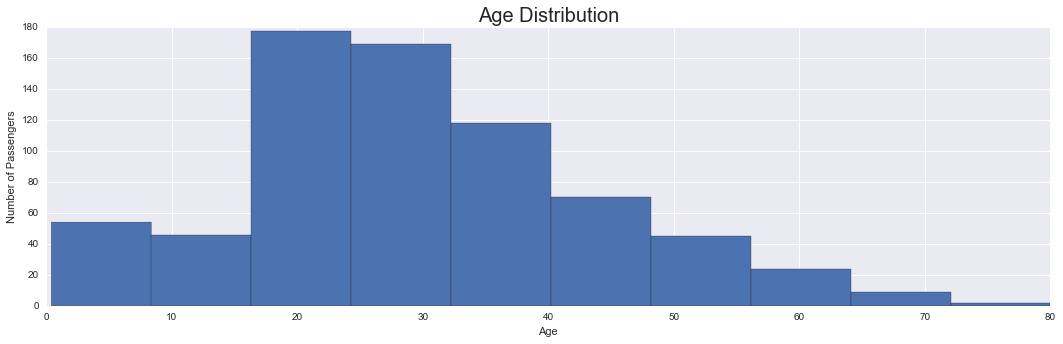

In [19]:
titandf['Age'].hist(figsize = (18,5))
plt.title('Age Distribution', fontsize = 20)
plt.xlabel('Age')
plt.ylabel('Number of Passengers')


Exactly - most passengers were on 20-40 range.

Sticking to the original question, I would like to do the same thing I have done for the fares: 

- Classify age groups 
- Measure survival rates in each group
- Add survival rate as an additional column

In [20]:
age_bins = [0,10,20,30,40,50,60,70,80]
age_group_names = ['0-10', '10-20','20-30','30-40','40-50','50-60','60-70','70-80']

titandf['Age_Group'] = pd.cut(titandf['Age'], age_bins, labels=age_group_names, include_lowest= True)

In [21]:
#Checking if it worked
titandf.loc[97]

Survived                                            0
Pclass                                              1
Name                        Goldschmidt, Mr. George B
Sex                                              male
Age                                                71
SibSp                                               0
Parch                                               0
Ticket                                       PC 17754
Fare                                          34.6542
Cabin                                              A5
Embarked                                            C
Fare_Group                                      30-40
Fare_Group_Survival_Rate                     0.396552
Age_Group                                       70-80
Name: 97, dtype: object

In [22]:
#Measure survival rate and add as a column

def survivor_percentage_age(age_group):
    
    age_group_size = titandf[titandf['Age_Group'] == age_group]
    survivors_in_group = len(age_group_size[titandf['Survived'] == 1])
    if survivors_in_group != 0:
        survivor_percentage = float(survivors_in_group) / float(len(age_group_size))
        return survivor_percentage
    else:
        return 0

titandf['Age_Group_Survival_Rate'] = titandf['Age_Group'].apply(survivor_percentage_age)

/Users/emreergin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [23]:
#Checking if it worked
titandf.loc[97]

Survived                                            0
Pclass                                              1
Name                        Goldschmidt, Mr. George B
Sex                                              male
Age                                                71
SibSp                                               0
Parch                                               0
Ticket                                       PC 17754
Fare                                          34.6542
Cabin                                              A5
Embarked                                            C
Fare_Group                                      30-40
Fare_Group_Survival_Rate                     0.396552
Age_Group                                       70-80
Age_Group_Survival_Rate                           0.2
Name: 97, dtype: object

In [24]:
survival_rates_for_age = category_survival_rate_df_generator('Age_Group', 'Age_Group_Survival_Rate')

In [25]:
survival_rates_for_age['BinLowerBound'] = survival_rates_for_age['Age_Group'].dropna().apply(binsize_splitter_low)

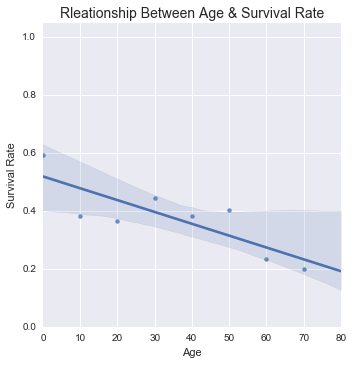

In [26]:
#Create a scatter plot using seaborn
g = sns.lmplot('BinLowerBound', 'Survival_Rate', data=survival_rates_for_age)

#Set labels and limits for both axis
g = (g.set_axis_labels("Age", "Survival Rate").set(xlim=(0.05, 80), ylim=(0, 1.05)))
plt.title('Rleationship Between Age & Survival Rate', fontsize = 14)

No surprises - likelihood of surviving decreases as the age increases. However, judging from the steepness of the line, age factor is not as strong as fare determining surviving likelihood. (Keep in mind this is not a weighted scatter plot, number of instances in each group is not taken into consideration)

### Gender

Considering there are only two variables in one dimension (female & male), I am just going to use a simple visualisation to showcase survivors in each gender.

<function matplotlib.pyplot.show>

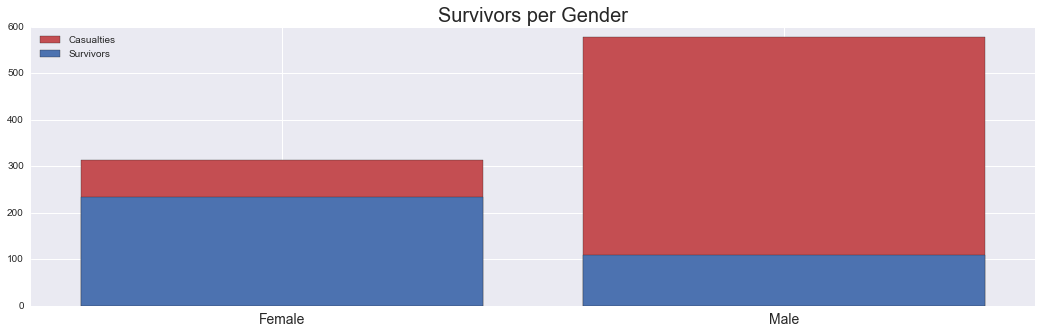

In [27]:
male_survivor_count = len(titandf[(titandf['Survived'] == 1)&(titandf['Sex'] =='male')])
female_survivor_count = len(titandf[(titandf['Survived'] == 1)&(titandf['Sex'] =='female')])
male_passenger_count = len(titandf[(titandf['Sex'] =='male')])
female_passenger_count = len(titandf[(titandf['Sex'] =='female')])

survivor_sex_array = [female_survivor_count, male_survivor_count]
overall_sex_array = [female_passenger_count, male_passenger_count]
genders = [1, 2]
gender_labels = ['Female', 'Male']

p1 = plt.bar(genders, overall_sex_array, color = 'r', align = 'center')
p2 = plt.bar(genders, survivor_sex_array, color = 'b', align = 'center')
plt.xticks(genders, gender_labels, fontsize = 14)
plt.title('Survivors per Gender', fontsize = 20)
plt.legend((p1[0], p2[0]), ('Casualties', 'Survivors'), loc='upper left')

plt.show


As expected, ratio of survivors among females are much higher than males - females are evacuated first. I'll add the survival rate column as I did for each factor.

In [28]:
def survivor_percentage_sex(sex):
    sex_group_size = titandf[titandf['Sex'] == sex]
    survivors_in_group = len(sex_group_size[titandf['Survived'] == 1])
    survivor_percentage = float(survivors_in_group) / float(len(sex_group_size))
    return survivor_percentage    

titandf['Sex_Survival_Rate'] = titandf['Sex'].apply(survivor_percentage_sex)

/Users/emreergin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


Lastly, printing survival rate for each gender.

In [29]:
survival_rate_for_gender = category_survival_rate_df_generator('Sex', 'Sex_Survival_Rate')
survival_rate_for_gender

,Sex,Survival_Rate
0,male,0.188908
1,female,0.742038


## Conclusions

Various conclusions have been made between the lines, so I will just outline a couple of things to wrap up this work:

* Paying more for the ticket increased the likelihood to survive.
* Survivor distribution based on genders show the men on Titanic were true gentlemen.
* Age groups 30-40 and 50-60 had surprisingly highest survival rates.
* Females, between 30-40 years of age, who paid more than £300 to travel in first class had the highest survival rates.
* Males, between 70-80 years if age, who paid less than £10 to travel in third class had the lowest survival rates.


### Limitations
* Please keep in mind this analysis ignored a lot of dependencies and various caveats, and completed just for the purpose of getting familiar with the process and tools.
* Number of passengers analyzed is significantly less than originial number of passengers in Titanic, and no effor was made to generalise the results.
* Around 20% of the passengers did not have the age data.
* Seperation of sibling and spouse numbers would allow further exploration i.e survival rate of couples with kids vs couples without kids

Thank you,

Emre Ergin